In [ ]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, GRU, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install session-info

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 5.5 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=ac6eba08fc4969b4fd7bb3e928b993a8de6f3b2935818ddb681581624f391a57
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [ ]:
from tensorflow import keras
import tensorflow as tf

In [ ]:
import session_info
session_info.show()

In [ ]:
!pip freeze > requirements.txt
!pip list --format=freeze > requirements.txt

In [ ]:
import sys
print(sys.modules.keys())

dict_keys(['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', '_io', 'marshal', 'posix', '_frozen_importlib_external', 'time', 'zipimport', '_codecs', 'codecs', 'encodings.aliases', 'encodings', 'encodings.utf_8', '_signal', '_abc', 'abc', 'io', '__main__', 'types', 'enum', '_sre', 'sre_constants', 'sre_parse', 'sre_compile', '_collections_abc', 'itertools', 'keyword', '_operator', 'operator', 'reprlib', '_collections', 'collections', '_functools', 'functools', '_locale', 'copyreg', 're', 'warnings', '_stat', 'stat', 'genericpath', 'posixpath', 'os.path', 'os', '_sitebuiltins', '_distutils_hack', 'importlib._bootstrap', 'importlib._bootstrap_external', 'importlib', 'importlib._abc', 'contextlib', 'importlib.util', 'importlib.machinery', 'google', 'google.cloud', 'google.logging', 'mpl_toolkits', 'sphinxcontrib', 'sitecustomize', 'site', 'runpy', 'ipykernel._version', '_json', 'json.scanner', 'json.decoder', 'json.encoder', 'json', 'errno', 'signal', '_w

# Load Data

In [ ]:
!mkdir '/content/data/'

In [ ]:
!unzip '/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge' -d '/content/data/'

Archive:  /content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge.zip
  inflating: /content/data/sample_submission.csv.zip  
  inflating: /content/data/test.csv.zip  
  inflating: /content/data/test_labels.csv.zip  
  inflating: /content/data/train.csv.zip  


In [ ]:
train=pd.read_csv("/content/data/train.csv.zip")
test=pd.read_csv("/content/data/test.csv.zip")

In [ ]:
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [ ]:
test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [ ]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train, test = train_test_split(train, test_size=0.2)

In [ ]:
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
77265,cefaef5751244984,The English dub episodes of Yu-Gi-Oh! Arc-V fo...,0,0,0,0,0,0
45988,7ae39594f5bdcf6d,No personal attacks \n\nI was not personally a...,0,0,0,0,0,0
60054,a0ba9aa9d74e4adc,"Important question \n\nHello neighbour, what'...",0,0,0,0,0,0
144665,109c74cdacb3e549,"That sounds good, but I have to say I'm a bit ...",0,0,0,0,0,0
39913,6a8a2f4d16bf4625,formating problem \n\nThe value is supposed to...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
54376,914b5c79987680c2,Hello asshole. Your mother might be a cross wi...,1,0,1,0,1,0
4429,0bc9fb959bbcc74c,"""\n I do know what the """"L"""" in BLP stands for...",0,0,0,0,0,0
135912,d6f779b6836c8093,A Response\nI am not sure if you are a moderat...,0,0,0,0,0,0
98526,0f09a7409a3e3d7a,Please desist from engaging in edit warring an...,0,0,0,0,0,0


In [ ]:
test

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
58520,9cb2b6aa698ea716,"""\n\nThat would be ideal if this were a huge, ...",0,0,0,0,0,0
123521,94adfb0664ee88db,Your edits in September and November 2009 \n\n...,0,0,0,0,0,0
2671,072c0470e510231c,citations of specific text,0,0,0,0,0,0
113906,61355ffbd5314485,"""\n\n Hi Edward. You have a few options. First...",0,0,0,0,0,0
150447,6c70eafd1a01b3b3,"Block\nHey man, sorry about that whole thing. ...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
69349,b987b70103fa3d02,"WP:(. BTW, in many cases articles that are not...",0,0,0,0,0,0
13626,23f7c12290ec1a50,Did you intend to remove my in this edit? I ...,0,0,0,0,0,0
14732,26e591aab8dbed73,link to The Historical Author of Anong Bahumon...,0,0,0,0,0,0
90803,f2e995028e90ca49,"""\n\n Quick Change \n\nI made a quick change: ...",0,0,0,0,0,0


In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train[list_classes].values
y_test = test[list_classes].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [ ]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

# Tokenizer

In [ ]:
list_tokenized_train[:1]

[[298, 50, 186, 28, 2415]]

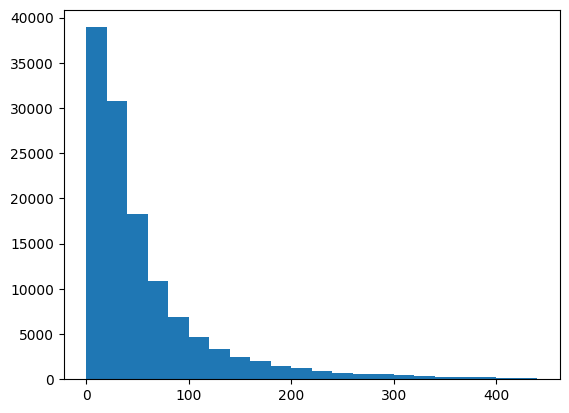

In [ ]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,450,20))
plt.show()

In [ ]:
maxlen = 200
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [ ]:
X_train.shape

(127656, 200)

In [ ]:
X_test.shape

(31915, 200)

# Model

In [ ]:
inp = Input(shape=(maxlen, ))

In [ ]:
#embedding
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

In [ ]:
#GRU
x = GRU(64, return_sequences=True,name='gru_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dense(32, activation="relu")(x)
x = Dense(6, activation="sigmoid")(x)

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          2560000   
                                                                 
 gru_layer (GRU)             (None, 200, 64)           37248     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                             

# Training

In [ ]:
batch_size = 32
epochs = 3
h = model.fit(X_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/3
3591/3591 [==============================] - 742s 205ms/step - loss: 0.0676 - accuracy: 0.9750 - val_loss: 0.0472 - val_accuracy: 0.9948
Epoch 2/3
3591/3591 [==============================] - 717s 200ms/step - loss: 0.0433 - accuracy: 0.9919 - val_loss: 0.0448 - val_accuracy: 0.9944
Epoch 3/3
3591/3591 [==============================] - 728s 203ms/step - loss: 0.0365 - accuracy: 0.9870 - val_loss: 0.0479 - val_accuracy: 0.9925


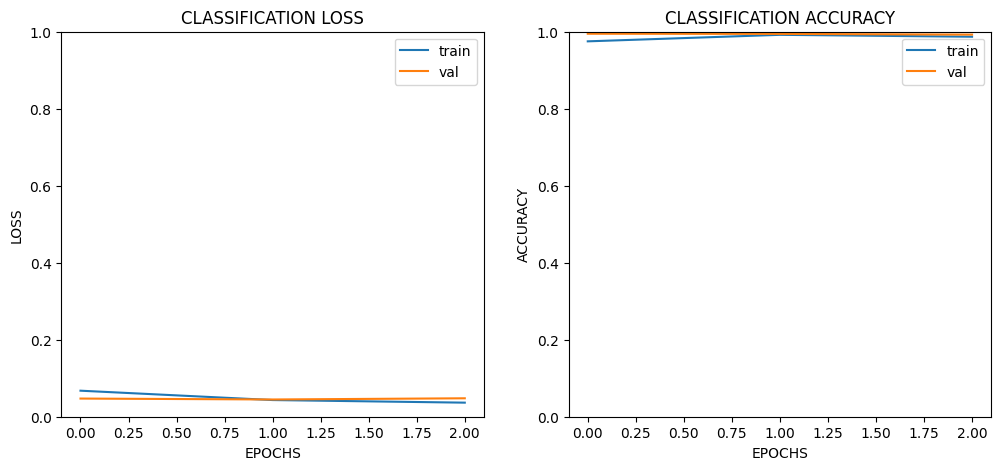

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(h.history['loss']);
plt.plot(h.history['val_loss']);
plt.title("CLASSIFICATION LOSS");
plt.ylabel("LOSS");
plt.ylim([0,1.0]);
plt.xlabel("EPOCHS");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(h.history['accuracy']);
plt.plot(h.history['val_accuracy']);
plt.title("CLASSIFICATION ACCURACY");
plt.ylabel("ACCURACY");
plt.ylim([0,1.0]);
plt.xlabel("EPOCHS");
plt.legend(['train', 'val']);

In [ ]:
model.evaluate(X_test,y_test)

998/998 [==============================] - 37s 37ms/step - loss: 0.0511 - accuracy: 0.9927


[0.05109105259180069, 0.9926680326461792]

In [ ]:
model.predict(X_test)

998/998 [==============================] - 35s 35ms/step


array([[2.3156010e-04, 4.0500848e-07, 4.6300509e-05, 1.8625460e-05,
        1.9624658e-05, 2.2898643e-05],
       [1.0075781e-02, 2.9178535e-05, 6.9230708e-04, 8.9340517e-04,
        1.1801943e-03, 6.7426119e-04],
       [2.2211477e-04, 4.4906724e-07, 2.7916356e-05, 2.4546242e-05,
        1.6619377e-05, 2.9243805e-05],
       ...,
       [8.2399514e-05, 1.4005228e-07, 2.8312483e-05, 3.5468944e-05,
        1.2710270e-05, 5.9714048e-06],
       [9.0532645e-05, 8.9771663e-07, 1.5822136e-05, 5.7807723e-05,
        8.1027883e-06, 2.1140731e-05],
       [2.7142800e-04, 4.6102886e-07, 6.1120190e-05, 3.0030526e-05,
        3.5888326e-05, 1.1270855e-05]], dtype=float32)

In [ ]:
text = ["test"]
tokenizer.fit_on_texts(text)
list_tokenized_test = tokenizer.texts_to_sequences(text)
text_X = pad_sequences(list_tokenized_test, maxlen=maxlen)


y_pred = model.predict(text_X)

1/1 [==============================] - 0s 55ms/step


In [ ]:
onearray =  np.ndarray.flatten(y_pred)
onearray



array([0.5002047 , 0.49110693, 0.49598557, 0.50274724, 0.49921358,
       0.5082038 ], dtype=float32)

In [ ]:
for i in range(len(onearray)):
  print('{0:f}'.format(onearray[i]*100))

50.020468
49.110693
49.598557
50.274724
49.921358
50.820380


In [ ]:
cd /content/drive/MyDrive/Toxic Classification

/content/drive/MyDrive/Toxic Classification


In [ ]:
model_architecture = model.to_json()

In [ ]:
model.save_weights('model_weights.h5')

In [ ]:
from tensorflow.keras.models import model_from_json
model1 = model_from_json(model_architecture)

In [ ]:
model1.load_weights('model_weights.h5')

In [ ]:
y_pred1 = model1.predict(text_X)
onearray1 =  np.ndarray.flatten(y_pred1)
onearray1


1/1 [==============================] - 0s 119ms/step


array([0.99901265, 0.35093036, 0.9941159 , 0.00545566, 0.91080195,
       0.01400941], dtype=float32)

In [ ]:
from keras.models import model_from_json
# serialize model to json
json_model = model.to_json()
#save the model architecture to JSON file
with open('fashionmnist_model.json', 'w') as json_file:
    json_file.write(json_model)
#saving the weights of the model
model.save_weights('thisis_weights.h5')

In [ ]:
#Reading the model from JSON file
with open('/content/drive/MyDrive/Toxic Classification/fashionmnist_model.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture
model_j = tf.keras.models.model_from_json(json_savedModel)
model_j.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 128)          2560000   
                                                                 
 gru_layer (GRU)             (None, 200, 64)           37248     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                             

In [ ]:
model_j.load_weights('/content/drive/MyDrive/Toxic Classification/thisis_weights.h5')

In [ ]:
model_j.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
loss,acc = model_j.evaluate(X_test,y_test)

998/998 [==============================] - 37s 36ms/step - loss: 0.6945 - accuracy: 0.1163
